# ◢ RecurSeed and CertainMix

This is a reference implementation of our paper, which presents attention maps per image. 
Should you be making use of our work, please cite our paper. 

In [2]:
import os
import cv2
import torch
import numpy as np

from PIL import Image
from matplotlib import pyplot as plt

from core import networks

from tools.ai import torch_utils, augment_utils, demo_utils
from tools.general import io_utils, json_utils, time_utils

# Preprocessing

In [3]:
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

test_transform = augment_utils.Compose([
    augment_utils.Normalize(imagenet_mean, imagenet_std),
    augment_utils.Transpose(),
])

In [4]:
data_dict = json_utils.read_json(f'./data/VOC.json')

class_names = np.asarray(data_dict['class_names'][1:])
colors = demo_utils.get_colors(data_dict)

In [6]:
model = networks.Modified_DeepLabv3_Plus(
    'resnet50', 
    cls_classes=data_dict['num_classes']-1, seg_classes=data_dict['num_classes'],
    norm_fn='bn', feature_size=256, output_stride=16, last_stride=1, 
    high_channels=256, freeze=False
)

model.eval()
if torch.cuda.is_available():
    model.cuda()

torch_utils.load_model(model, './experiments/models/ResNet50@VOC@DeepLabv3+@RS_and_CM/last.pth')

# Inference

In [7]:
image = Image.open('./resources/2007_002619_Image.png')
# image = Image.open('./resources/2007_009346_Image.png')
w, h = image.size

tensor = test_transform({'image': image, 'mask': None})['image']
tensor = torch.from_numpy(tensor)

if torch.cuda.is_available():
    tensor = tensor.cuda()

params = {
    "image": tensor,
    "image_size": (h, w),
    "scales": [1.0, 0.5, 1.5, 2.0],
    "hflip": True,

    "with_cls": True,
    "with_cam": False,
    "with_segment": True,
    "with_single": False,
}
output_dict = model.forward_with_scales(**params)

pred_class = output_dict['pred_class']
pred_mask = output_dict['pred_mask']

# Postprocessing

In [8]:
conf_th = 0.50

pred_class = torch_utils.get_numpy(pred_class)[0]
label = (pred_class >= conf_th).astype(np.float32)

np_label = label.copy()

label = torch.from_numpy(label).cuda()
class_mask = label[:, None, None]

class_keys = np.nonzero(np_label)[0]
class_keys = np.pad(class_keys + 1, (1, 0), 'constant')

seed = torch_utils.normalize(pred_mask[0, 1:] * class_mask)
seed = seed[label == 1]

# Visualization

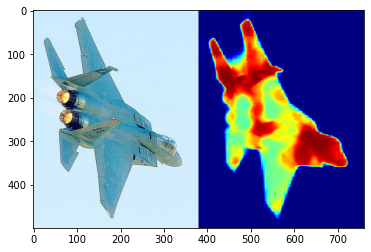

In [9]:
cv_image = demo_utils.convert_PIL_to_OpenCV(image)

np_seed = torch_utils.get_numpy(seed)
np_seed = demo_utils.convert_cam(np_seed)

demo = np.concatenate([cv_image, np_seed], axis=1)

plt.imshow(demo[..., ::-1])